In [1]:
from unicodedata import category
import json
import codecs
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import csv
import re
import pandas as pd
import seaborn as sns
import matplotlib
from sentence_transformers import SentenceTransformer

D:\apps\envs\pytorch2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot for citation network

In [2]:
# # SETUP 
# import seaborn as sns 
# plt.style.use('seaborn-paper')

# #plt.rc('font', family='Avenir', serif='Computer Modern')
# text_size = 22
# plt.rc('text', usetex=True)
# plt.rc('xtick', labelsize=text_size)
# plt.rc('ytick', labelsize=text_size)
# plt.rc('axes', labelsize=text_size)
# plt.rc('axes', titlesize=text_size)
# plt.rc('legend',fontsize=18) # using a size in points
# plt.rcParams['axes.linewidth'] = 1.15
# plt.rcParams["figure.figsize"] = (6.,4.1631189606246317)
# #plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

# rc = {"axes.spines.left" : True,
#       "axes.spines.right" : True,
#       "axes.spines.bottom" : True,
#       "axes.spines.top" : True,
#       "xtick.bottom" : True,
#       "xtick.labelbottom" : True,
#       "ytick.labelleft" : True,
#       "ytick.left" : True
#      }

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     #"font.sans-serif": ["Helvetica"]}
#     "text.usetex": True,
#     "pgf.texsystem": "pdflatex",
#     "pgf.preamble": r"\usepackage{bm}",
#     "font.family": "serif",
#     # Use LaTeX default serif font.
#     "font.serif": ["Times"],
#     # Use specific cursive fonts.
#     "font.cursive": ["Comic Neue", "Comic Sans MS"],

# })

# plt.rcParams.update(rc)

In [3]:
def conn_sig(x, y, color='b', beta=1, linewidth=2, alpha=0.01):
    x_ = np.linspace(-5, 5)
    x_adj = np.linspace(*x)
    sig = 1/(1+np.exp(-x_*beta))
    sig = (sig-sig.min())/sig.max()
    sig_adj = sig *(y[1]-y[0]) + y[0]
    plt.plot(x_adj, sig_adj, color=color, linewidth=linewidth, alpha=alpha)


In [4]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")

In [44]:
n_components = 2
tsne = TSNE(n_components, random_state=500)

In [45]:
### Open json file
with open('./citation_dict_keyword.json') as f:
    citation_dict_keyword = json.load(f)

citation_dict_temp = copy.deepcopy(citation_dict_keyword)


paper_list = []
count_list = []
id_list = []

##### start to add papers from each category
import string
types_of_encoding = ["utf8"] #"cp1252"
title2idx= {}
for encoding_type in types_of_encoding:
    with codecs.open('./idx_paper.csv', encoding = encoding_type, errors ='replace') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            line = ''.join(row)
            title = line.split(';')[-1]
            # for character in string.punctuation:
            #     title = title.replace(character, '')
            title = re.sub(r'[^\w\s]', '', title)
            title2idx[title.lower()] = int(row[0].split(';')[0])


In [46]:
counter = 0
edge_candidates = {}

keyword_list = []
dot_weight = []
## read from dict and save key words
for k, v_list in citation_dict_temp.items():
    counter += len(v_list)
    for v in v_list:
        if 'keywords' in v:
            if type(v['keywords']) is dict:
                keyword = ''
                if 'application area' in v['keywords']:
                    if type(v['keywords']['application area']) is list:
                        if len(v['keywords']['application area']) > 0:
                            keyword = v['keywords']['application area'][0].title()
                    else:
                        keyword = v['keywords']['application area'].title()
#             else:
#                 keyword = v['keywords'][0][0]


            ### save the key word embeddings
            # keyword_list.append(keywords[0][0])
            # if keywords[0][0] == 'automation':
            #     print(k, v['title'])
            #dot_weight.append(v['count']*8)
            if not keyword in list(edge_candidates.keys()):
                edge_candidates[keyword] = []
            k = re.sub(r'[^\w\s]', '', k)
            try:
                edge_candidates[keyword].append(title2idx[k])
                keyword_list.append(keyword)
            except:
                continue


In [47]:
keyword_cls = list(set(keyword_list))
dot_weight = np.zeros((len(keyword_cls)))
keyword_embeddings = []
label_group = []
for kword in keyword_list:
    label_group.append(keyword_cls.index(kword))
    dot_weight[keyword_cls.index(kword)] += 1

In [48]:
keyword_embeddings = []
for kword in keyword_cls:
    k_embedding = np.asarray(sentence_model.encode(kword))
    # k_embedding = k_embedding.mean(axis=0)
    keyword_embeddings.append(k_embedding)
keyword_embeddings = np.asarray(keyword_embeddings)

In [49]:
tsne_result = tsne.fit_transform(np.asarray(keyword_embeddings))
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'keyword': keyword_cls, 'size':dot_weight}) # 
tsne_result_df_filter = tsne_result_df[tsne_result_df['size'] > 2]
tsne_result_df_filter = tsne_result_df_filter[tsne_result_df['size'] < 30]
tsne_result_df_filter = tsne_result_df_filter[1:]

exclude_words = ['Artificial', 'Ai', 'Xai', 'Image', 'Interpretability', 'Machine', 'Decision', 'Technology']
for exclude in exclude_words:
    tsne_result_df_filter = tsne_result_df_filter[~(tsne_result_df_filter['keyword'].str.contains(exclude))]

tsne_result_df_filter.tsne_1 = 10 + 40 * (tsne_result_df_filter.tsne_1 - tsne_result_df_filter.tsne_1.min())/(tsne_result_df_filter.tsne_1.max()-tsne_result_df_filter.tsne_1.min())
tsne_result_df_filter.tsne_2 = 40 * (tsne_result_df_filter.tsne_2 - tsne_result_df_filter.tsne_2.min())/(tsne_result_df_filter.tsne_2.max()-tsne_result_df_filter.tsne_2.min())


C:\Users\Yao\AppData\Local\Temp\ipykernel_26640\2484210609.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tsne_result_df_filter = tsne_result_df_filter[tsne_result_df['size'] < 30]


In [50]:
print(tsne_result_df_filter)

        tsne_1     tsne_2                      keyword  size
1    35.482849   2.910488     Creativity Support Tools   3.0
9    28.491669   1.714241               Graphic Design   4.0
12   43.237984  12.190495         Software Development   3.0
13   45.641830  24.009434          Algorithmic Systems   4.0
22   31.402916   0.000000              User Experience   5.0
92   28.780817  34.660603        Information Retrieval   6.0
94   16.302313  29.194950              Medical Imaging   3.0
99   37.817528  38.950726                Deep Learning   4.0
106  15.490566  24.445068            Medical Diagnosis   3.0
116  33.202110  40.000000              Computer Vision   6.0
150  14.027204   7.861488                    Education   5.0
162  12.125204  18.856945             Criminal Justice   3.0
188  30.071899  26.619947                Data Analysis   9.0
208  33.622696  11.484332          Recommender Systems   4.0
248  26.173851  30.141127                   Typography   3.0
286  27.305649   8.15792

In [51]:
# fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 5)
# sns.set_theme(style="white")
# p1 = sns.scatterplot(x='tsne_1', y='tsne_2', hue='keyword', data=tsne_result_df_filter, ax=ax, s=tsne_result_df_filter['size']*10, alpha=.4, palette="rocket") #"muted"
# # ### select cls to show on plot
# # np_cls_count = np.zeros((len(keyword_cls),))
# # for cls in label_group:
# #     np_cls_count[cls] += 1

# ### add text near selected dots
# cluster_center_list = []
# word_shown_list = []

# for line in range(0, tsne_result_df_filter.shape[0]):
#     shown_word = tsne_result_df_filter.iloc[line].keyword
#     if 'Recommender' in shown_word:
#         shown_word = 'Recommendation Systems'
#     if 'Software Engineering' in shown_word:
#         shown_word = 'Software Development'
#     if shown_word in word_shown_list:
#         continue
#     ss = tsne_result_df_filter.iloc[line]['size']
#     if ss > 10:
#         ss = 10
#     if ss < 5 : 
#         ss = 8
#     ax.annotate(shown_word, (tsne_result_df_filter.iloc[line].tsne_1, tsne_result_df_filter.iloc[line].tsne_2), fontsize=ss, color='black', ha='center', va='baseline')
#     cluster_center_list.append([tsne_result_df_filter.iloc[line].tsne_1, tsne_result_df_filter.iloc[line].tsne_2])
#     word_shown_list.append(shown_word)
# #     else:
# #         if keyword_cls[line] == 'nlp':
# #                 edge_candidates_new['nlp'] = edge_candidates[keyword_cls[line]]
# #                 keyword_cls[line] = 'NLP'
# #         else:
# #             edge_candidates_new[keyword_cls[line].capitalize()] = edge_candidates[keyword_cls[line]]
# #             keyword_cls[line] = keyword_cls[line].capitalize()
# #         if keyword_cls[line] in ['Biometrics', 'Wellness', 'Blockchain', 'NLP', 'Human-in-the-loop', 'Experts', 'Prosocial', 'Social', 'Robots', 'Breastscreening', 'Analystics', 'Media']:
# #             ss = 9
# #             ax.annotate(keyword_cls[line], (tsne_result_df.tsne_1[line], tsne_result_df.tsne_2[line]), fontsize=ss, color='black', ha='center', va='baseline')

# cluster_center_np = np.asarray(cluster_center_list)
# lim = (tsne_result.min()-10, tsne_result.max()+10)
# #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# #ax.set_aspect('equal')
# ax.set_axis_off()
# ax.get_legend().remove()

# idx2category = {}
# paper_unique = []
# for encoding_type in types_of_encoding:
#     with codecs.open('allpapers_new.csv', encoding = encoding_type, errors ='replace') as csvfile:
#         csvreader = csv.reader(csvfile)
#         for row in csvreader:
#             line = ''.join(row)
#             title = line.split(';')[1]
#             title = re.sub(r'[^\w\s]', '', title)
#             paper_unique.append(title)
#             if not title.lower() in title2idx.keys():
#                 print(title)
#                 continue
#             idx = title2idx[title.lower()]
#             if not idx in idx2category:
#                 idx2category[idx] = []
#             idx2category[idx].append(line.split(';')[-1])
# # print(len(idx2category.keys())) ## founded papers in the title2idx list
# # print(len(list(set(paper_unique))))
# # exit()

# #### plot papers in the same area (left lower part)
# category_list = {'trust':0, 'team':1,  'understanding':2, 'usability':3} # 'fairness':1, 
# category_list_final = ['Trust', 'Human-AI Collaboration',  'Understanding','Usability']
# point_x_range = [[tsne_result.min(), tsne_result.min()], [tsne_result.min()-5, tsne_result.min()+10], [tsne_result.min(), tsne_result.min()+5], [tsne_result.min()+3, tsne_result.min()+5]]
# point_y_range = [[tsne_result.min()-2, tsne_result.min()], [tsne_result.min()+20, tsne_result.min()+25], [tsne_result.max()-20, tsne_result.max()-10], [tsne_result.max()+5, tsne_result.max()+10]]
# color_list = ['green', 'darkorange', 'violet', 'lightcoral'] #'dodgerblue', 

# for i, cls in enumerate(keyword_cls):
#     try:
#         paper_id = edge_candidates[cls]
#         #sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df.iloc(i), ax=ax, s=dot_weight[i]*10, alpha=.4, palette="rocket") #"muted"
#     except:
#         continue
#     for idx in paper_id:
#         try:
#             categ_list =  idx2category[idx]
#             for categ in categ_list:
#                 beta = np.random.uniform(low=0.5, high=1.5)
#                 conn_sig(x=[point_x_range[category_list[categ]][0], tsne_result_df_filter.tsne_1[i]], y=[point_y_range[category_list[categ]][0], tsne_result_df_filter.tsne_2[i]], color=color_list[category_list[categ]], beta=beta, linewidth=1, alpha=0.05)
#         except:
#             continue
# for k, v_categ in category_list.items():
#     ax.annotate(category_list_final[v_categ], (point_x_range[v_categ][0],point_y_range[v_categ][0]), fontsize=18, color='navy', horizontalalignment='center')

# # plt.show()
# #plt.savefig('2citation_plot.pdf', dpi=600)


# Plot Reference network

In [52]:
### Open json file
with open('./reference_dict_keyword.json') as f:
    reference_dict_keyword = json.load(f)

reference_dict_temp = copy.deepcopy(reference_dict_keyword)

ref_keyword_list = []
ref_dot_weight = []
ref_edge_candidates = []

ref_paper_list = []
ref_count_list = []
ref_id_list = []

for k, v in reference_dict_temp.items():
    # if v['count'] > 5:
    #     count_list.append(v['count'])
    #     paper_list.append(v['title'])
    #     id_list.append(k)
    #     #continue
    if 'keywords' in v:
        #print(k, v['title'])
        if type(v['keywords']) is dict:
            if 'keywords' in v['keywords']:
                if type(v['keywords']['keywords']) is list:
                    if len(v['keywords']['keywords']) > 0:
                        keyword = v['keywords']['keywords'][0].title()
                        ### save the key word embeddings
                        ref_keyword_list.append(keyword)
                        # if keywords[0][0] == 'automation':
                        #     print(k, v['title'])
                        ref_dot_weight.append(v['count'])
                        ref_edge_candidates.append(v['referenced_by'])

ref_keyword_cls = list(set(ref_keyword_list))
ref_keyword_embeddings = []
ref_label_group = []
for kword in ref_keyword_list:
    ref_label_group.append(ref_keyword_cls.index(kword))
    k_embedding = sentence_model.encode(kword)
    ref_keyword_embeddings.append(k_embedding)

## plot embedding in tSNE 
tsne_result = tsne.fit_transform(np.array(ref_keyword_embeddings))
ref_tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'keyword': ref_keyword_list, 'size':ref_dot_weight, 'label': ref_label_group, 'reference_by': ref_edge_candidates}) # 
# ## save the dict with key words    
# tsne_result_df.to_csv("./for_viz/reference_dots.csv")  
# print(tsne_result_df)
# exit()



In [53]:

ref_tsne_result_df_filter = ref_tsne_result_df[ref_tsne_result_df['size'] > 5]

exclude_words = ['Artificial', 'Ai', 'Xai', 'Image', 'Interpretability', 'Machine', 'Decision', 'Technology', 'Explanations']
for exclude in exclude_words:
    ref_tsne_result_df_filter = ref_tsne_result_df_filter[~(ref_tsne_result_df_filter['keyword'].str.contains(exclude))]
    
    
ref_tsne_result_df_filter.tsne_1 = -20 -45 * (ref_tsne_result_df_filter.tsne_1 - ref_tsne_result_df_filter.tsne_1.min())/(ref_tsne_result_df_filter.tsne_1.max()-ref_tsne_result_df_filter.tsne_1.min())
ref_tsne_result_df_filter.tsne_2 = 40 * (ref_tsne_result_df_filter.tsne_2 - ref_tsne_result_df_filter.tsne_2.min())/(ref_tsne_result_df_filter.tsne_2.max()-ref_tsne_result_df_filter.tsne_2.min())


In [54]:
ref_tsne_result_df_filter

,tsne_1,tsne_2,keyword,size,label,reference_by
1,-22.079916,19.944887,Imperfect Algorithms,12,40,"[0, 4, 10, 13, 25, 26, 51, 58, 59, 68, 76, 79]"
5,-44.102016,10.040349,Explanation,17,52,"[0, 4, 5, 9, 26, 30, 40, 42, 43, 44, 55, 57, 5..."
7,-54.613602,12.841987,Trust,7,68,"[0, 12, 14, 26, 45, 55, 73]"
8,-55.290104,17.072689,Deception Detection,11,6,"[0, 12, 26, 30, 39, 58, 60, 63, 69, 76, 78]"
11,-39.784462,6.118034,Axiomatic Attribution,10,11,"[0, 2, 4, 10, 41, 48, 49, 52, 78, 96]"
...,...,...,...,...,...,...
114,-35.222359,1.856983,Fairness,6,56,"[18, 20, 21, 32, 34, 77]"
115,-64.724243,28.425911,Hybrid Recommender System,9,7,"[19, 36, 55, 57, 81, 83, 84, 88, 92]"
121,-44.083271,37.761650,Neural Predictions,7,57,"[24, 26, 29, 32, 41, 47, 61]"
122,-44.924843,11.773389,Explanation,6,52,"[25, 31, 32, 33, 57, 65]"


In [55]:
ref_tsne_result_df_filter.keyword.tolist()

['Imperfect Algorithms',
 'Explanation',
 'Trust',
 'Deception Detection',
 'Axiomatic Attribution',
 'Trust',
 'Shap',
 'Explainable Systems',
 'Transparency Design',
 'Deep Learning',
 'Deep Learning',
 'Black-Box Predictions',
 'Intelligibility',
 'Context-Aware Applications',
 'Context-Aware Intelligent Systems',
 'Attribution',
 'Anchors',
 'Grad-Cam',
 'Convolutional Networks',
 'Gdpr',
 'Need For Cognition',
 'Medical Practitioners',
 'Algorithm Aversion',
 'Trust',
 'Confidence',
 'Intelligible Models',
 'European Union Regulations',
 'Judgment',
 'Design Guidelines',
 'Algorithmic Interfaces',
 'Recommender Systems',
 'Saliency Maps',
 'Cnns',
 'Fairness Judgments',
 'Deep Learning',
 'Intelligent Systems',
 'Recommendations',
 'Intelligible Intelligence',
 'Nasa-Tlx',
 'Predictive Models',
 'Intelligent Agents',
 'Transparency',
 'Fairness',
 'Intelligent Agent',
 'Trust Building',
 'Transparency',
 'Thematic Analysis',
 'Automated Rationale Generation',
 'Recommender Systems

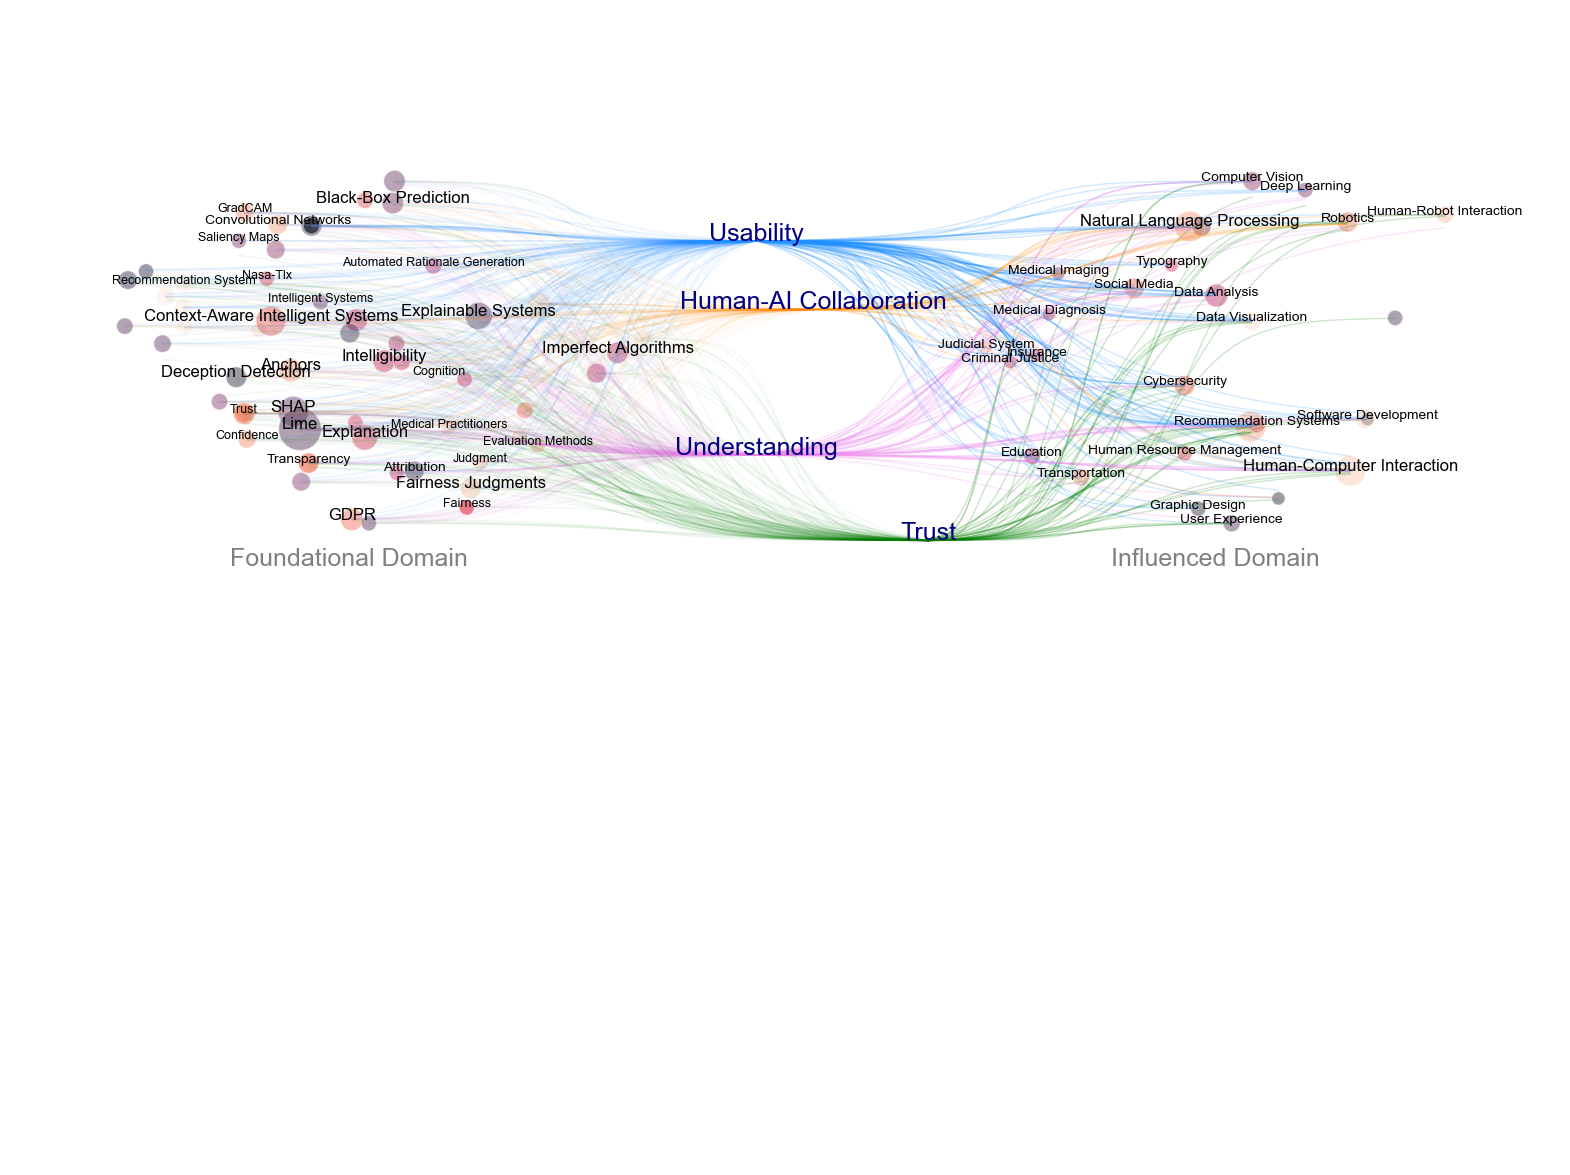

In [58]:
fig, ax = plt.subplots(1)
fig.set_size_inches(20, 15)
sns.set_theme(style="white")
p1 = sns.scatterplot(x='tsne_1', y='tsne_2', hue='keyword', data=tsne_result_df_filter, ax=ax, s=tsne_result_df_filter['size']*30, alpha=.4, palette="rocket") #"muted"
### add text near selected dots
cluster_center_list = []
word_shown_list = []

for line in range(0, tsne_result_df_filter.shape[0]):
    shown_word = tsne_result_df_filter.iloc[line].keyword
    if 'Recommender' in shown_word:
        shown_word = 'Recommendation Systems'
    if 'Software Engineering' in shown_word:
        shown_word = 'Software Development' 
    if 'Algorithmic' in shown_word or 'Tools' in shown_word or 'Information' in shown_word:
        continue
    if shown_word in word_shown_list:
        continue
    ss = tsne_result_df_filter.iloc[line]['size']
    if ss > 10:
        ss = 12
    elif ss < 10 : 
        ss = 10
    ax.annotate(shown_word, (tsne_result_df_filter.iloc[line].tsne_1, tsne_result_df_filter.iloc[line].tsne_2), fontsize=ss, color='black', ha='center', va='baseline')
    cluster_center_list.append([tsne_result_df_filter.iloc[line].tsne_1, tsne_result_df_filter.iloc[line].tsne_2])
    word_shown_list.append(shown_word)

idx2category = {}
paper_unique = []
for encoding_type in types_of_encoding:
    with codecs.open('allpapers_new.csv', encoding = encoding_type, errors ='replace') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            line = ''.join(row)
            title = line.split(';')[1]
            title = re.sub(r'[^\w\s]', '', title)
            paper_unique.append(title)
            if not title.lower() in title2idx.keys():
                continue
            idx = title2idx[title.lower()]
            if not idx in idx2category:
                idx2category[idx] = []
            idx2category[idx].append(line.split(';')[-1])


#### plot papers in the same area (left lower part)
category_list = {'trust':0, 'team':1,  'understanding':2, 'usability':3} # 'fairness':1, 
category_list_final = ['Trust', 'Human-AI Collaboration',  'Understanding','Usability']
point_x_range = [[5, 10], [-5, 0], [-10, -12], [-10, -15]]
point_y_range = [[-2, 0], [25, 25], [8, 8], [33, 33]]
color_list = ['green', 'darkorange', 'violet', 'dodgerblue'] #'dodgerblue', 

for i, cls in enumerate(keyword_cls):
    try:
        paper_id = edge_candidates[cls]
    except:
        continue
    if i in tsne_result_df_filter.index:
        for idx in paper_id:
            try:
                categ_list =  idx2category[idx]
                for categ in categ_list:
                    beta = np.random.uniform(low=0.5, high=1.5)
                    conn_sig(x=[point_x_range[category_list[categ]][0], tsne_result_df_filter.tsne_1[i]], y=[point_y_range[category_list[categ]][0], tsne_result_df_filter.tsne_2[i]], color=color_list[category_list[categ]], beta=beta, linewidth=1, alpha=0.2)
            except:
                continue
for k, v_categ in category_list.items():
    ax.annotate(category_list_final[v_categ], (point_x_range[v_categ][0],point_y_range[v_categ][0]), fontsize=18, color='navy', horizontalalignment='center')

#########################

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=ref_tsne_result_df_filter, ax=ax, s=ref_tsne_result_df_filter['size']*20,  alpha=.4, palette="rocket",) #"muted"

### add text near selected dots
ref_shown_word_list = []

for line in range(0, ref_tsne_result_df_filter.shape[0]):
    shown_word = ref_tsne_result_df_filter.iloc[line].keyword
    if 'Recommender' in shown_word:
        shown_word = 'Recommendation System'
    if 'Trust' in shown_word:
        shown_word = 'Trust'
    if 'European' in shown_word or 'Gdpr' in shown_word:
        shown_word = 'GDPR'
    if 'Cognition' in shown_word:
        shown_word = 'Cognition'
    if 'Design' in shown_word or 'Recommendations' in shown_word or 'Agents' in shown_word or 'Agent' in shown_word:
        continue
    if  'Cnns' in shown_word or 'Deep' in shown_word or 'Applications' in shown_word or 'Intelligence' in shown_word:
        continue
    if  'Models' in shown_word or 'Analysis' in shown_word or 'Aversion' in shown_word or 'Algorithmic' in shown_word:
        continue
#     if 'Explanation' in shown_word:
#         shown_word = 'Model Explanation'
    if 'Attribution' in shown_word:
        shown_word = 'Attribution'
    if 'Predictive' in shown_word or 'Predictions' in shown_word:
        shown_word = 'Black-Box Prediction'
    if 'Line' in shown_word:
        shown_word = 'LIME'
    if 'Shap' in shown_word:
        shown_word = 'SHAP'
    if 'Grad' in shown_word:
        shown_word = 'GradCAM'
    if shown_word in ref_shown_word_list:
        continue
    ss = ref_tsne_result_df_filter.iloc[line]['size']
    if ss > 10:
        ss = 12
    elif ss < 10: 
        ss = 9
    ax.annotate(shown_word, (ref_tsne_result_df_filter.iloc[line].tsne_1, ref_tsne_result_df_filter.iloc[line].tsne_2), fontsize=ss, color='black', ha='center', va='baseline')
    ref_shown_word_list.append(shown_word)



for line in range(0, ref_tsne_result_df_filter.shape[0]):
    paper_id = ref_tsne_result_df_filter.iloc[line].reference_by
    for idx in paper_id:
        try:
            categ_list =  idx2category[idx]
            for categ in categ_list:
                beta = np.random.uniform(low=0.5, high=1.5)
                conn_sig(x=[point_x_range[category_list[categ]][0], ref_tsne_result_df_filter.iloc[line].tsne_1], y=[point_y_range[category_list[categ]][0], ref_tsne_result_df_filter.iloc[line].tsne_2], color=color_list[category_list[categ]], beta=beta, linewidth=1, alpha=0.05)
        except:
            continue

lim = (ref_tsne_result_df_filter.tsne_1.min()-10, tsne_result_df_filter.tsne_1.max()+10)
ax.set_xlim(lim)
ax.set_ylim(lim)

ax.annotate('Foundational Domain', (ref_tsne_result_df_filter.tsne_1.min()*0.7, -5), fontsize=18, color='gray', ha='center', va='baseline')
ax.annotate('Influenced Domain', (tsne_result_df_filter.tsne_1.max()*0.6, -5), fontsize=18, color='gray', ha='center', va='baseline')

#ax.set_aspect('equal')
ax.set_axis_off()
ax.get_legend().remove()
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# plt.show()
plt.savefig('combined.pdf', dpi=600)